In [1]:
from util_input_output_model import *
from collections import defaultdict
from datetime import timedelta
import tensorflow as tf
import numpy as np
import pandas as pd
import time
provinces = ['Bangkok','Chanthaburi','Chiang Mai','Kanchanaburi','Songkhla','Khon Kaen']

features = ['PM2.5','WindDir','Wind Speed(km/h)','Temp(C)','Cambodia_frp','Myanmar_frp','Thailand_frp','Lao_PDR_frp']
tf.__version__

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


'2.5.0-rc1'

## Preparing data
We'll preparing `X, Y` of `Train, Test` set.

In [2]:
print("Enter timestep : ",end=' ')
timesteps = int(input())
print(timesteps)

Enter timestep :  168


In [3]:
feature_used = features
Train_data, X_train, Y_train = prepare_train_data(timesteps, feature_used = feature_used)

In [4]:
Test_data, X_test, Y_test = prepare_test_data(Train_data, timesteps, feature_used = feature_used)

dif : 163
2019-03-18 08:00:00
base = 2019-03-18 12:00:00
dif : 157
2019-03-18 08:00:00
base = 2019-03-18 18:00:00
dif : 151
2019-03-18 08:00:00
base = 2019-03-19 00:00:00
dif : 145
2019-03-18 08:00:00
base = 2019-03-19 06:00:00


## Standardize the data
Next, we need to scale the data.

In [5]:
x_train_scalers, y_train_scalers, X_train_scaled, Y_train_scaled = scale_data(X_train, Y_train, Train_data)
x_test_scalers, y_test_scalers, X_test_scaled, Y_test_scaled = scale_data(X_test, Y_test, Test_data)

## Shaping
Make sure that the data is in the right shape. The `X` shape should be `(#datapoints, #timesteps, #features)`. The `Y` shape should be `(#datapoints, 72)` since each forecast we have to predict next 72 hours.

In [6]:
x_, y_ = {}, {}

for p in provinces:
    x_[p] = {"Train": np.array(X_train_scaled[p]),
             "Test": np.array(X_test_scaled[p])}
    
    y_[p] = {"Train": np.array(Y_train_scaled[p]).squeeze(axis=2),
             "Test": np.array(Y_test_scaled[p]).squeeze(axis=2)}

    print(p)
    print(f'X Train: {x_[p]["Train"].shape}')
    print(f'Y Train: {y_[p]["Train"].shape}')
    print(f'X Test: {x_[p]["Test"].shape}')
    print(f'Y Test: {y_[p]["Test"].shape}\n')

Bangkok
X Train: (4398, 168, 7)
Y Train: (4398, 72)
X Test: (1454, 168, 7)
Y Test: (1454, 72)

Chanthaburi
X Train: (4398, 168, 7)
Y Train: (4398, 72)
X Test: (1454, 168, 7)
Y Test: (1454, 72)

Chiang Mai
X Train: (4398, 168, 7)
Y Train: (4398, 72)
X Test: (1454, 168, 7)
Y Test: (1454, 72)

Kanchanaburi
X Train: (4398, 168, 7)
Y Train: (4398, 72)
X Test: (1454, 168, 7)
Y Test: (1454, 72)

Songkhla
X Train: (4398, 168, 7)
Y Train: (4398, 72)
X Test: (1454, 168, 7)
Y Test: (1454, 72)

Khon Kaen
X Train: (1968, 168, 7)
Y Train: (1968, 72)
X Test: (1454, 168, 7)
Y Test: (1454, 72)



## Building Model

In [7]:
print(f"timesteps : {timesteps}")

timesteps : 168


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout
import tensorflow as tf

n_features = len(feature_used)-1

# define model
model = Sequential([
    GRU(100, activation='relu', input_shape=(timesteps, n_features), return_sequences=True),
    Dropout(rate=0.1),
    GRU(60, activation='relu'),
    Dropout(rate=0.1),
    Dense(72, activation='linear')
])

In [16]:
province = 'Chiang Mai'
x_feed, y_feed = x_[province]['Train'], y_[province]['Train']
x_eval, y_eval = x_[province]['Test'], y_[province]['Test']

In [17]:
# Last check for null values
print(np.isnan(x_feed).any())
print(np.isnan(y_feed).any())
print(np.isnan(x_eval).any())
print(np.isnan(y_eval).any())

False
False
False
False


In [27]:
model.compile(optimizer=tf.keras.optimizers.Adamax(), loss='mse')

# TensorBoard
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
run_log_dir = "./my_logs/"+run_id
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                        patience=10, restore_best_weights=True)
# Nan stopping
nan_stop = tf.keras.callbacks.TerminateOnNaN()

history = model.fit(x_feed, y_feed, validation_data=(x_eval, y_eval), 
                    epochs=50, batch_size=32,
                    callbacks=[tensorboard_cb, early_stop, nan_stop])

# tensorboard --logdir=.\my_logs --port=6006

Epoch 1/50
138/138 [==============================] - 44s 296ms/step - loss: 0.0152 - val_loss: 0.0178
Epoch 2/50
138/138 [==============================] - 39s 280ms/step - loss: 0.0136 - val_loss: 0.0179
Epoch 3/50
138/138 [==============================] - 39s 285ms/step - loss: 0.0141 - val_loss: 0.0217
Epoch 4/50
138/138 [==============================] - 39s 280ms/step - loss: 0.0096 - val_loss: 0.0230
Epoch 5/50
138/138 [==============================] - 39s 283ms/step - loss: 0.0078 - val_loss: 0.0238
Epoch 6/50
138/138 [==============================] - 39s 281ms/step - loss: 0.0068 - val_loss: 0.0206
Epoch 7/50
138/138 [==============================] - 42s 303ms/step - loss: 0.0065 - val_loss: 0.0201
Epoch 8/50
138/138 [==============================] - 39s 285ms/step - loss: 0.0064 - val_loss: 0.0226
Epoch 9/50
138/138 [==============================] - 41s 294ms/step - loss: 0.0059 - val_loss: 0.0207
Epoch 10/50
138/138 [==============================] - 39s 284ms/step - l

In [61]:
model.fit(x_feed, y_feed, validation_data=(x_eval, y_eval), 
                    epochs=50, batch_size=32,
                    callbacks=[tensorboard_cb, early_stop, nan_stop])

Epoch 1/50
135/135 [==============================] - 160s 1s/step - loss: 0.0109 - val_loss: 0.0160
Epoch 2/50
135/135 [==============================] - 170s 1s/step - loss: 0.0107 - val_loss: 0.0134
Epoch 3/50
135/135 [==============================] - 172s 1s/step - loss: 0.0104 - val_loss: 0.0164
Epoch 4/50
135/135 [==============================] - 169s 1s/step - loss: 0.0102 - val_loss: 0.0149
Epoch 5/50
135/135 [==============================] - 167s 1s/step - loss: 0.0101 - val_loss: 0.0155
Epoch 6/50
135/135 [==============================] - 170s 1s/step - loss: 0.0099 - val_loss: 0.0194
Epoch 7/50
135/135 [==============================] - 167s 1s/step - loss: 0.0099 - val_loss: 0.0165
Epoch 8/50
135/135 [==============================] - 169s 1s/step - loss: 0.0098 - val_loss: 0.0163
Epoch 9/50
135/135 [==============================] - 167s 1s/step - loss: 0.0097 - val_loss: 0.0174
Epoch 10/50
135/135 [==============================] - 169s 1s/step - loss: 0.0098 - val_lo

In [69]:
#model.save(f"./Models/{province}_{run_id}.h5")

### Evaluate on train

In [28]:
model.evaluate(x_eval, y_eval)

46/46 [==============================] - 2s 53ms/step - loss: 0.0178


0.017845910042524338

### Evaluate on test

In [29]:
from sklearn.metrics import mean_squared_error as mse
pred = model(x_eval)
rmse = []
print('province :', province)
for i in range(len(pred)):
    p = y_test_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
    y_t = y_test_scalers[province].inverse_transform(y_eval[i].reshape((-1,1)))
    rmse.append(np.sqrt(mse(p, y_t)))
np.mean(rmse)

province : Chiang Mai


23.370243589615573

province = Chiang Mai


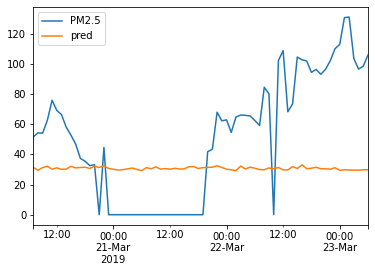

In [33]:
i = 7
print('province =',province)
h = y_test_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
k = Y_test[province][i].copy()
k['pred'] = h
k.plot();

## Save the model
- **Bangkok** : `./Models/Bangkok_run_2021_04_25-08_23_07.h5` (12.92)
    - features\[:4]
    - 720 timesteps
- **Chanthaburi** : `./Models/Chanthaburi_run_2021_04_25-13_57_13.h5` (9.58) 
    - features\[:3]
   - 720 timesteps

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx